# Week 1: 0D Bang-Bang Control Analytical Analysis

## Newton's Law of Cooling (ODE, 0D)

$$\frac{dT}{dt} = -k(T(t) - T_a) + u(t)$$

### Variables
| Symbol | Meaning |
|--------|---------|
| $T(t)$ | Indoor temperature (real-time) |
| $T_a$ | Outdoor (ambient) temperature |
| $u(t)$ | Heating input |
| $T_{set}$ | Thermostat set-point |
| $T_H = T_{set} + \delta$ | Upper threshold |
| $T_L = T_{set} - \delta$ | Lower threshold |
| $k$ | Cooling constant |
| $\delta$ | Hysteresis half-band |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Output directory
RESULT_DIR = os.path.join(os.path.dirname(os.path.abspath('.')), 
                          os.path.abspath('Result'))
os.makedirs(RESULT_DIR, exist_ok=True)

# --- Physical Parameters (matching Code/utils/parameters.py) ---
T_a = 5.0        # Outdoor temperature (°C)
T_set = 20.0     # Set-point temperature (°C)
k = 0.1          # Cooling constant (1/min)
U_max = 15.0     # Max heating rate (°C/min)
T_initial = 10.0 # Initial room temperature (°C)

# Derived
T_ss = T_a + U_max / k  # Steady-state when heater always ON
print(f"Parameters:")
print(f"  T_a = {T_a}°C, T_set = {T_set}°C, k = {k} 1/min, U_max = {U_max} °C/min")
print(f"  Steady-state (heater ON): T_ss = T_a + U_max/k = {T_ss}°C")

Parameters:
  T_a = 5.0°C, T_set = 20.0°C, k = 0.1 1/min, U_max = 15.0 °C/min
  Steady-state (heater ON): T_ss = T_a + U_max/k = 155.0°C


## 1. ODE Analytical Solution Derivation

From Newton's Law of Cooling:

$$\frac{dT}{dt} = -k(T(t) - T_a) + u(t) \implies \frac{dT}{dt} + kT = kT_a + u(t)$$

Multiply both sides by the integrating factor $e^{kt}$:

$$e^{kt}\left(\frac{dT}{dt} + kT\right) = [kT_a + u(t)]\,e^{kt}$$

$$\implies \frac{d}{dt}\left[e^{kt}\,T(t)\right] = [kT_a + u(t)]\,e^{kt}$$

Integrate both sides from $t_0$ to $t$ (since $kT_a + u(t)$ is constant within each segment):

$$\left[e^{kt}\,T(t)\right]_{t_0}^{t} = \frac{1}{k}(kT_a + u_t)(e^{kt} - e^{kt_0})$$

$$\implies e^{kt}T(t) = e^{kt_0}T(t_0) + \frac{1}{k}(kT_a + u_t)(e^{kt} - e^{kt_0})$$

$$\implies T(t) = e^{-k(t-t_0)}T(t_0) + \left(T_a + \frac{u_t}{k}\right)\left(1 - e^{-k(t-t_0)}\right)$$

**0D Analytical Solution (boxed formula from Handnote):**

$$\boxed{T(t) = T_a + \frac{u_t}{k} + e^{-k(t-t_0)}\left(T(t_0) - T_a - \frac{u_t}{k}\right)}$$

> **Note**: This holds as long as $u(t)$ is constant within each time segment.

### Case 1: Heater OFF ($u = 0$)
$$T_{\text{off}}(t) = T_a + (T(t_0) - T_a)\, e^{-k(t - t_0)} \implies \text{temperature decays to} \; T_a \;\text{(outdoor temperature)}$$

### Case 2: Heater ON ($u = U_{max}$)
$$T_{\text{on}}(t) = T_a + \frac{U_{max}}{k} + \left(T(t_0) - T_a - \frac{U_{max}}{k}\right) e^{-k(t - t_0)} \implies \text{temperature rises exponentially to} \; T_{ss}$$

In [2]:
def T_analytical(t, T0, t0, u_t, k=k, T_a=T_a):
    """General 0D analytical solution for constant u_t on [t0, t]."""
    return T_a + u_t / k + np.exp(-k * (t - t0)) * (T0 - T_a - u_t / k)

def T_off(t, T0, t0=0):
    """Heater OFF: u = 0."""
    return T_analytical(t, T0, t0, u_t=0)

def T_on(t, T0, t0=0):
    """Heater ON: u = U_max."""
    return T_analytical(t, T0, t0, u_t=U_max)

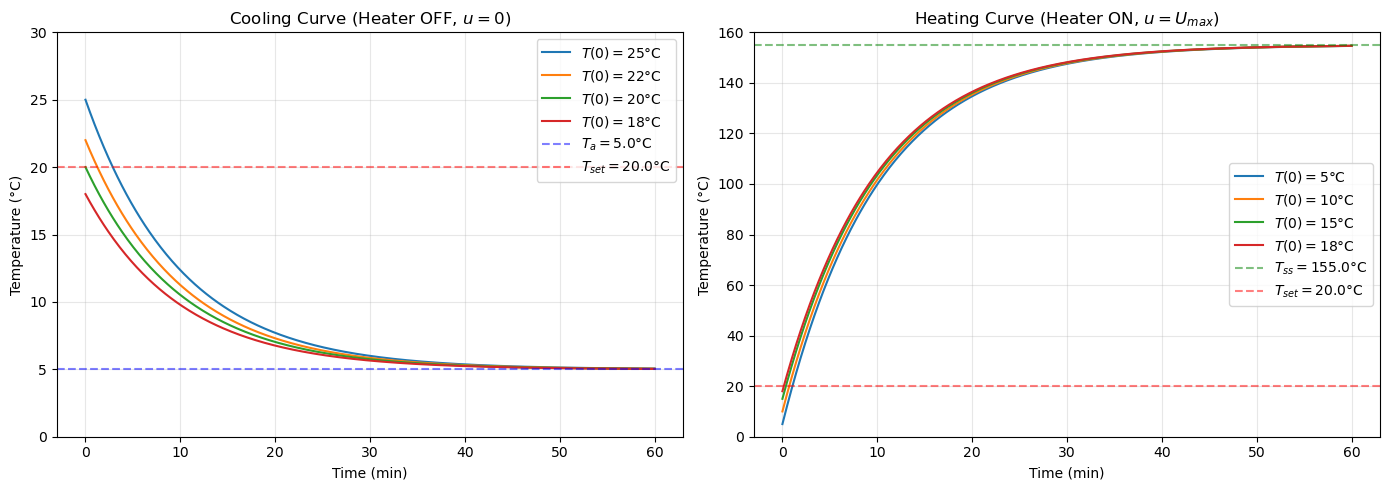

Saved: fig1_heating_cooling_curves.png


In [3]:
# --- Figure 1: Heating and Cooling Curves ---
t = np.linspace(0, 60, 500)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Cooling curve: start from T_set, heater OFF
ax = axes[0]
for T0_val in [25, 22, 20, 18]:
    T_cool = T_off(t, T0_val)
    ax.plot(t, T_cool, label=f'$T(0) = {T0_val}$°C')
ax.axhline(T_a, color='blue', ls='--', alpha=0.5, label=f'$T_a = {T_a}$°C')
ax.axhline(T_set, color='red', ls='--', alpha=0.5, label=f'$T_{{set}} = {T_set}$°C')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Cooling Curve (Heater OFF, $u = 0$)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 30)

# (b) Heating curve: start from various T0, heater ON
ax = axes[1]
for T0_val in [5, 10, 15, 18]:
    T_heat = T_on(t, T0_val)
    ax.plot(t, T_heat, label=f'$T(0) = {T0_val}$°C')
ax.axhline(T_ss, color='green', ls='--', alpha=0.5, label=f'$T_{{ss}} = {T_ss}$°C')
ax.axhline(T_set, color='red', ls='--', alpha=0.5, label=f'$T_{{set}} = {T_set}$°C')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Heating Curve (Heater ON, $u = U_{max}$)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 160)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig1_heating_cooling_curves.png'), dpi=150)
plt.show()
print("Saved: fig1_heating_cooling_curves.png")

## 2. Heating/Cooling Time Derivation (Handnote Step 1)

Next we compute the heating time, period, energy consumption, and switching count for the 0D case.

We now have the ON/OFF expressions. Assume starting from $T_{set} - \delta$ and $T_{set} + \delta$ respectively (i.e., $T(t_0)$ equals these two values).

### Heating time $t_{\text{on}}$

Heat from $T_{set} - \delta$ to $T_{set}$ (heater ON, $u = U_{max}$):

$$T_{set} = T_a + \frac{U_{max}}{k} + \left(T_{set} - \delta - T_a - \frac{U_{max}}{k}\right) e^{-kt_{\text{on}}}$$

$$\implies T_{set} - \left(T_a + \frac{U_{max}}{k}\right) = \left(T_{set} - \delta - T_a - \frac{U_{max}}{k}\right) e^{-kt_{\text{on}}}$$

$$\implies e^{-kt_{\text{on}}} = \frac{T_{set} - \left(T_a + \frac{U_{max}}{k}\right)}{T_{set} - \delta - \left(T_a + \frac{U_{max}}{k}\right)}$$

$$\boxed{t_{\text{on}} = \frac{1}{k} \ln\left(\frac{T_{set} - \delta - \left(T_a + \frac{U_{max}}{k}\right)}{T_{set} - \left(T_a + \frac{U_{max}}{k}\right)}\right)}$$

### Cooling time $t_{\text{off}}$

Similarly, the cooling phase from $T_{set} + \delta$ to $T_{set}$ (heater OFF, $u = 0$):

$$\boxed{t_{\text{off}} = \frac{1}{k} \ln\left(\frac{T_{set} + \delta - T_a}{T_{set} - T_a}\right)}$$

### Warning: Zeno Phenomenon!

As $\delta \to 0$, both $t_{\text{on}}$ and $t_{\text{off}}$ tend to $\ln(1) = 0$, so the **Zeno phenomenon emerges**!

That is, infinitely many switches occur in finite time — this is physically unrealisable.

In [ ]:
# === Handnote Step 1: Half-band (T_set±δ → T_set) ===

def t_kai_half(delta, k=k, T_a=T_a, U_max=U_max, T_set=T_set):
    """t_on (Handnote Step 1): heating time, from T_set - δ to T_set."""
    T_ss = T_a + U_max / k
    numerator = T_set - delta - T_ss   # T_set - δ - (T_a + U_max/k)
    denominator = T_set - T_ss          # T_set - (T_a + U_max/k)
    return (1.0 / k) * np.log(numerator / denominator)

def t_guan_half(delta, k=k, T_a=T_a, T_set=T_set):
    """t_off (Handnote Step 1): cooling time, from T_set + δ to T_set."""
    numerator = T_set + delta - T_a    # T_set + δ - T_a
    denominator = T_set - T_a          # T_set - T_a
    return (1.0 / k) * np.log(numerator / denominator)

# === Handnote Step 2: Full-band (T_L → T_H, T_H → T_L) ===
# (defined in advance, needed for later plots)

def compute_t_kai(T_L, T_H, k=k, T_a=T_a, U_max=U_max):
    """t_on: heating time, from T_L to T_H (heater ON)."""
    T_ss = T_a + U_max / k
    if T_ss <= T_H:
        return float('inf')
    return (1.0 / k) * np.log((T_L - T_ss) / (T_H - T_ss))

def compute_t_guan(T_L, T_H, k=k, T_a=T_a):
    """t_off: cooling time, from T_H to T_L (heater OFF)."""
    if T_L <= T_a:
        return float('inf')
    return (1.0 / k) * np.log((T_H - T_a) / (T_L - T_a))

# --- Verify half-band formulas ---
delta = 0.5
t_kai = t_kai_half(delta)
t_guan = t_guan_half(delta)

print("=" * 60)
print("Handnote Step 1: Half-band derivation (T_set ± δ → T_set)")
print("=" * 60)
print(f"  delta = {delta}°C")
print(f"  t_on  (heating: T_set-δ → T_set) = {t_kai:.6f} min")
print(f"  t_off (cooling: T_set+δ → T_set) = {t_guan:.6f} min")

# Verify Zeno: delta → 0 implies t_on, t_off → 0
print(f"\n--- Zeno verification (δ → 0) ---")
for d in [1.0, 0.5, 0.1, 0.01, 0.001]:
    tk = t_kai_half(d)
    tg = t_guan_half(d)
    print(f"  δ = {d:>6.3f}°C: t_on = {tk:.6f} min, t_off = {tg:.6f} min, "
          f"half-period = {tk + tg:.6f} min")
print(f"\n  → As δ → 0, both t_on and t_off → ln(1) = 0: Zeno phenomenon!")

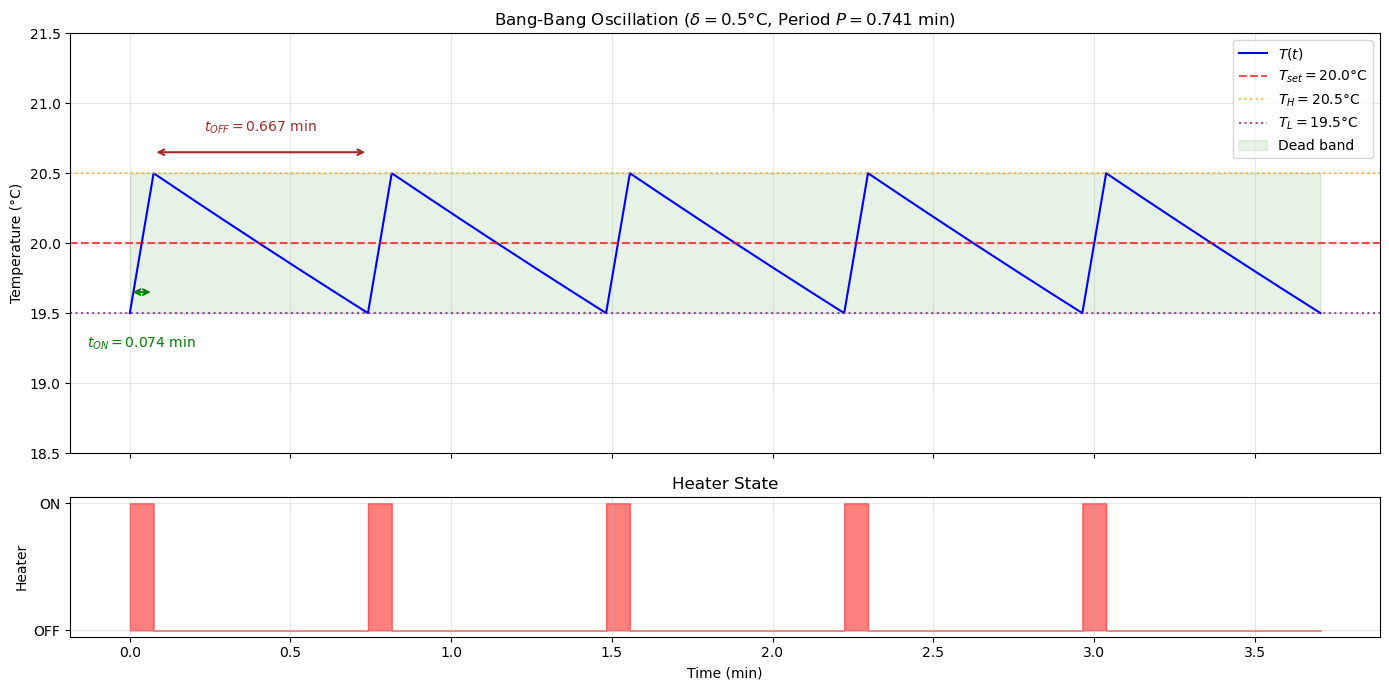

Saved: fig2_bangbang_oscillation.png


In [5]:
# --- Figure 2: Bang-Bang Oscillation (T_set, T_H, T_L, t_kai, t_guan) ---
delta = 0.5
T_H = T_set + delta
T_L = T_set - delta

t_kai_val = compute_t_kai(T_L, T_H)
t_guan_val = compute_t_guan(T_L, T_H)
P_val = t_kai_val + t_guan_val

# Simulate 5 full cycles from T_L (heater ON)
n_cycles = 5
t_total = []
T_total = []
heater_state = []

t_cursor = 0
for i in range(n_cycles):
    # Heating: T_L -> T_H
    t_seg = np.linspace(0, t_kai_val, 200)
    T_seg = T_on(t_seg, T_L)
    t_total.extend(t_seg + t_cursor)
    T_total.extend(T_seg)
    heater_state.extend([1] * len(t_seg))
    t_cursor += t_kai_val
    
    # Cooling: T_H -> T_L
    t_seg = np.linspace(0, t_guan_val, 200)
    T_seg = T_off(t_seg, T_H)
    t_total.extend(t_seg + t_cursor)
    T_total.extend(T_seg)
    heater_state.extend([0] * len(t_seg))
    t_cursor += t_guan_val

t_total = np.array(t_total)
T_total = np.array(T_total)
heater_state = np.array(heater_state)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), height_ratios=[3, 1], sharex=True)

ax1.plot(t_total, T_total, 'b-', linewidth=1.5, label='$T(t)$')
ax1.axhline(T_set, color='red', ls='--', alpha=0.7, label=f'$T_{{set}} = {T_set}$°C')
ax1.axhline(T_H, color='orange', ls=':', alpha=0.7, label=f'$T_H = {T_H}$°C')
ax1.axhline(T_L, color='purple', ls=':', alpha=0.7, label=f'$T_L = {T_L}$°C')
ax1.fill_between(t_total, T_L, T_H, alpha=0.1, color='green', label='Dead band')

# Annotate t_kai and t_guan on first cycle
ax1.annotate('', xy=(t_kai_val, T_L + 0.15), xytext=(0, T_L + 0.15),
             arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))
ax1.text(t_kai_val / 2, T_L - 0.25, f'$t_{{ON}} = {t_kai_val:.3f}$ min', 
         ha='center', fontsize=10, color='green')

ax1.annotate('', xy=(t_kai_val + t_guan_val, T_H + 0.15), xytext=(t_kai_val, T_H + 0.15),
             arrowprops=dict(arrowstyle='<->', color='brown', lw=1.5))
ax1.text(t_kai_val + t_guan_val / 2, T_H + 0.3, f'$t_{{OFF}} = {t_guan_val:.3f}$ min', 
         ha='center', fontsize=10, color='brown')

ax1.set_ylabel('Temperature (°C)')
ax1.set_title(f'Bang-Bang Oscillation ($\\delta = {delta}$°C, Period $P = {P_val:.3f}$ min)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(T_L - 1, T_H + 1)

ax2.fill_between(t_total, heater_state, step='mid', alpha=0.5, color='red')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Heater')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['OFF', 'ON'])
ax2.set_title('Heater State')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig2_bangbang_oscillation.png'), dpi=150)
plt.show()
print("Saved: fig2_bangbang_oscillation.png")

## 3. Resolution: Wider Temperature Band $T_H$, $T_L$ (Handnote Step 2)

**Resolving the Zeno problem**: use a wider temperature band, no longer targeting $T_{set}$ directly, but instead:

$$T_{set} + \delta \to T_H, \quad T_{set} - \delta \to T_L$$

Heat from $T_L$ to $T_H$, cool from $T_H$ to $T_L$:

### Heating time $t_{\text{on}}$ (from $T_L$ to $T_H$)

$$\boxed{t_{\text{on}} = \frac{1}{k} \ln\left(\frac{T_L - \left(T_a + \frac{U_{max}}{k}\right)}{T_H - \left(T_a + \frac{U_{max}}{k}\right)}\right)}$$

### Cooling time $t_{\text{off}}$ (from $T_H$ to $T_L$)

$$\boxed{t_{\text{off}} = \frac{1}{k} \ln\left(\frac{T_H - T_a}{T_L - T_a}\right)}$$

### Derived Quantities

- **Period**: $P = t_{\text{on}} + t_{\text{off}}$
- **Number of switches**: $\frac{2}{P} \times T_{total}$ (each period has ON→OFF and OFF→ON, i.e. 2 switching events)
- **Energy consumption**: $E = \int_0^P u(t)\,dt = U_{max} \cdot t_{\text{on}}$ (no energy consumed when OFF)
- **If each switch costs energy $\epsilon$, total energy**: $E_{total} = \text{switches} \times \epsilon + E$

Handnote Step 2: Full-band (T_L -> T_H, T_H -> T_L)
  delta = 0.5°C, T_H = 20.5°C, T_L = 19.5°C
  t_ON  (T_L -> T_H) = 0.074074 min
  t_OFF (T_H -> T_L) = 0.666914 min
  Period P = t_ON + t_OFF = 0.740988 min

--- Half-band vs Full-band ---
  Half t_ON (T_set-d -> T_set)  = 0.036969 min
  Full t_ON (T_L -> T_H)        = 0.074074 min
  Ratio: full/half = 2.0037

  Half t_OFF (T_set+d -> T_set) = 0.327898 min
  Full t_OFF (T_H -> T_L)       = 0.666914 min
  Ratio: full/half = 2.0339


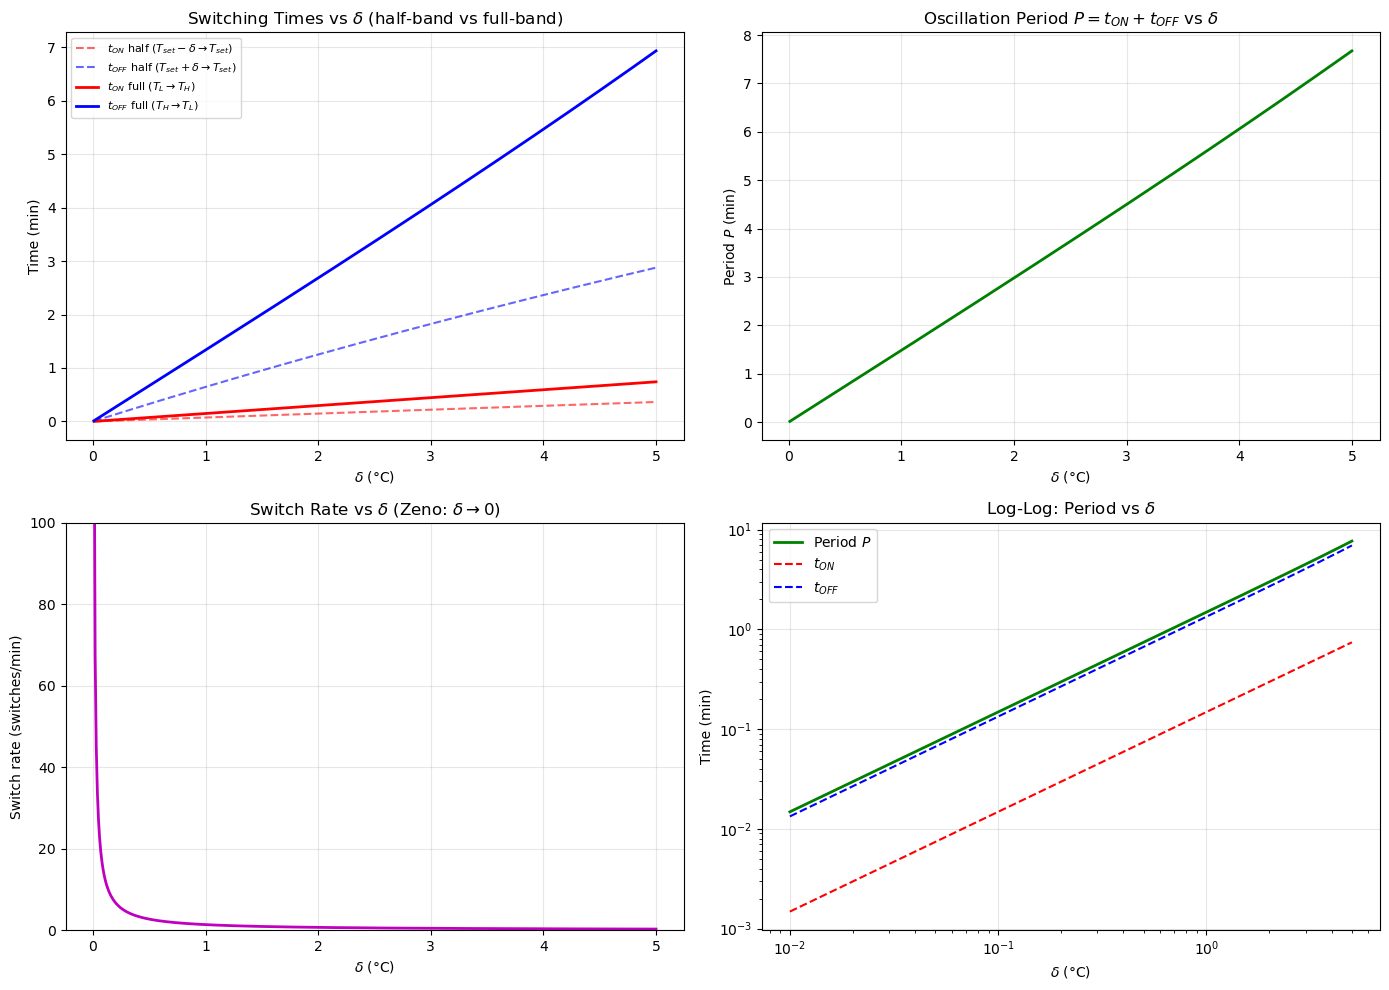

Saved: fig3_zeno_effect.png


In [6]:
# === Full-band calculation + Zeno comparison plot ===

delta = 0.5
T_H = T_set + delta
T_L = T_set - delta

t_kai_full = compute_t_kai(T_L, T_H)
t_guan_full = compute_t_guan(T_L, T_H)
P = t_kai_full + t_guan_full

print("=" * 60)
print("Handnote Step 2: Full-band (T_L -> T_H, T_H -> T_L)")
print("=" * 60)
print(f"  delta = {delta}°C, T_H = {T_H}°C, T_L = {T_L}°C")
print(f"  t_ON  (T_L -> T_H) = {t_kai_full:.6f} min")
print(f"  t_OFF (T_H -> T_L) = {t_guan_full:.6f} min")
print(f"  Period P = t_ON + t_OFF = {P:.6f} min")

print(f"\n--- Half-band vs Full-band ---")
print(f"  Half t_ON (T_set-d -> T_set)  = {t_kai_half(delta):.6f} min")
print(f"  Full t_ON (T_L -> T_H)        = {t_kai_full:.6f} min")
print(f"  Ratio: full/half = {t_kai_full / t_kai_half(delta):.4f}")
print(f"\n  Half t_OFF (T_set+d -> T_set) = {t_guan_half(delta):.6f} min")
print(f"  Full t_OFF (T_H -> T_L)       = {t_guan_full:.6f} min")
print(f"  Ratio: full/half = {t_guan_full / t_guan_half(delta):.4f}")

# --- Figure 3: Zeno Effect (half-band + full-band) ---
deltas = np.linspace(0.01, 5.0, 500)

t_kai_halfs = [t_kai_half(d) for d in deltas]
t_guan_halfs = [t_guan_half(d) for d in deltas]
t_kai_fulls = []
t_guan_fulls = []
periods = []
switch_rates = []

for d in deltas:
    TL = T_set - d
    TH = T_set + d
    tk = compute_t_kai(TL, TH)
    tg = compute_t_guan(TL, TH)
    p = tk + tg
    t_kai_fulls.append(tk)
    t_guan_fulls.append(tg)
    periods.append(p)
    switch_rates.append(2.0 / p if p > 0 else float('inf'))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) t_ON and t_OFF vs delta (both versions)
ax = axes[0, 0]
ax.plot(deltas, t_kai_halfs, 'r--', alpha=0.6, label='$t_{ON}$ half ($T_{set}-\\delta \\to T_{set}$)')
ax.plot(deltas, t_guan_halfs, 'b--', alpha=0.6, label='$t_{OFF}$ half ($T_{set}+\\delta \\to T_{set}$)')
ax.plot(deltas, t_kai_fulls, 'r-', linewidth=2, label='$t_{ON}$ full ($T_L \\to T_H$)')
ax.plot(deltas, t_guan_fulls, 'b-', linewidth=2, label='$t_{OFF}$ full ($T_H \\to T_L$)')
ax.set_xlabel('$\\delta$ (°C)')
ax.set_ylabel('Time (min)')
ax.set_title('Switching Times vs $\\delta$ (half-band vs full-band)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (b) Period vs delta
ax = axes[0, 1]
ax.plot(deltas, periods, 'g-', linewidth=2)
ax.set_xlabel('$\\delta$ (°C)')
ax.set_ylabel('Period $P$ (min)')
ax.set_title('Oscillation Period $P = t_{ON} + t_{OFF}$ vs $\\delta$')
ax.grid(True, alpha=0.3)

# (c) Switch rate vs delta (Zeno divergence)
ax = axes[1, 0]
ax.plot(deltas, switch_rates, 'm-', linewidth=2)
ax.set_xlabel('$\\delta$ (°C)')
ax.set_ylabel('Switch rate (switches/min)')
ax.set_title('Switch Rate vs $\\delta$ (Zeno: $\\delta \\to 0$)')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# (d) Log-log
ax = axes[1, 1]
ax.loglog(deltas, periods, 'g-', linewidth=2, label='Period $P$')
ax.loglog(deltas, t_kai_fulls, 'r--', label='$t_{ON}$')
ax.loglog(deltas, t_guan_fulls, 'b--', label='$t_{OFF}$')
ax.set_xlabel('$\\delta$ (°C)')
ax.set_ylabel('Time (min)')
ax.set_title('Log-Log: Period vs $\\delta$')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig3_zeno_effect.png'), dpi=150)
plt.show()
print("Saved: fig3_zeno_effect.png")

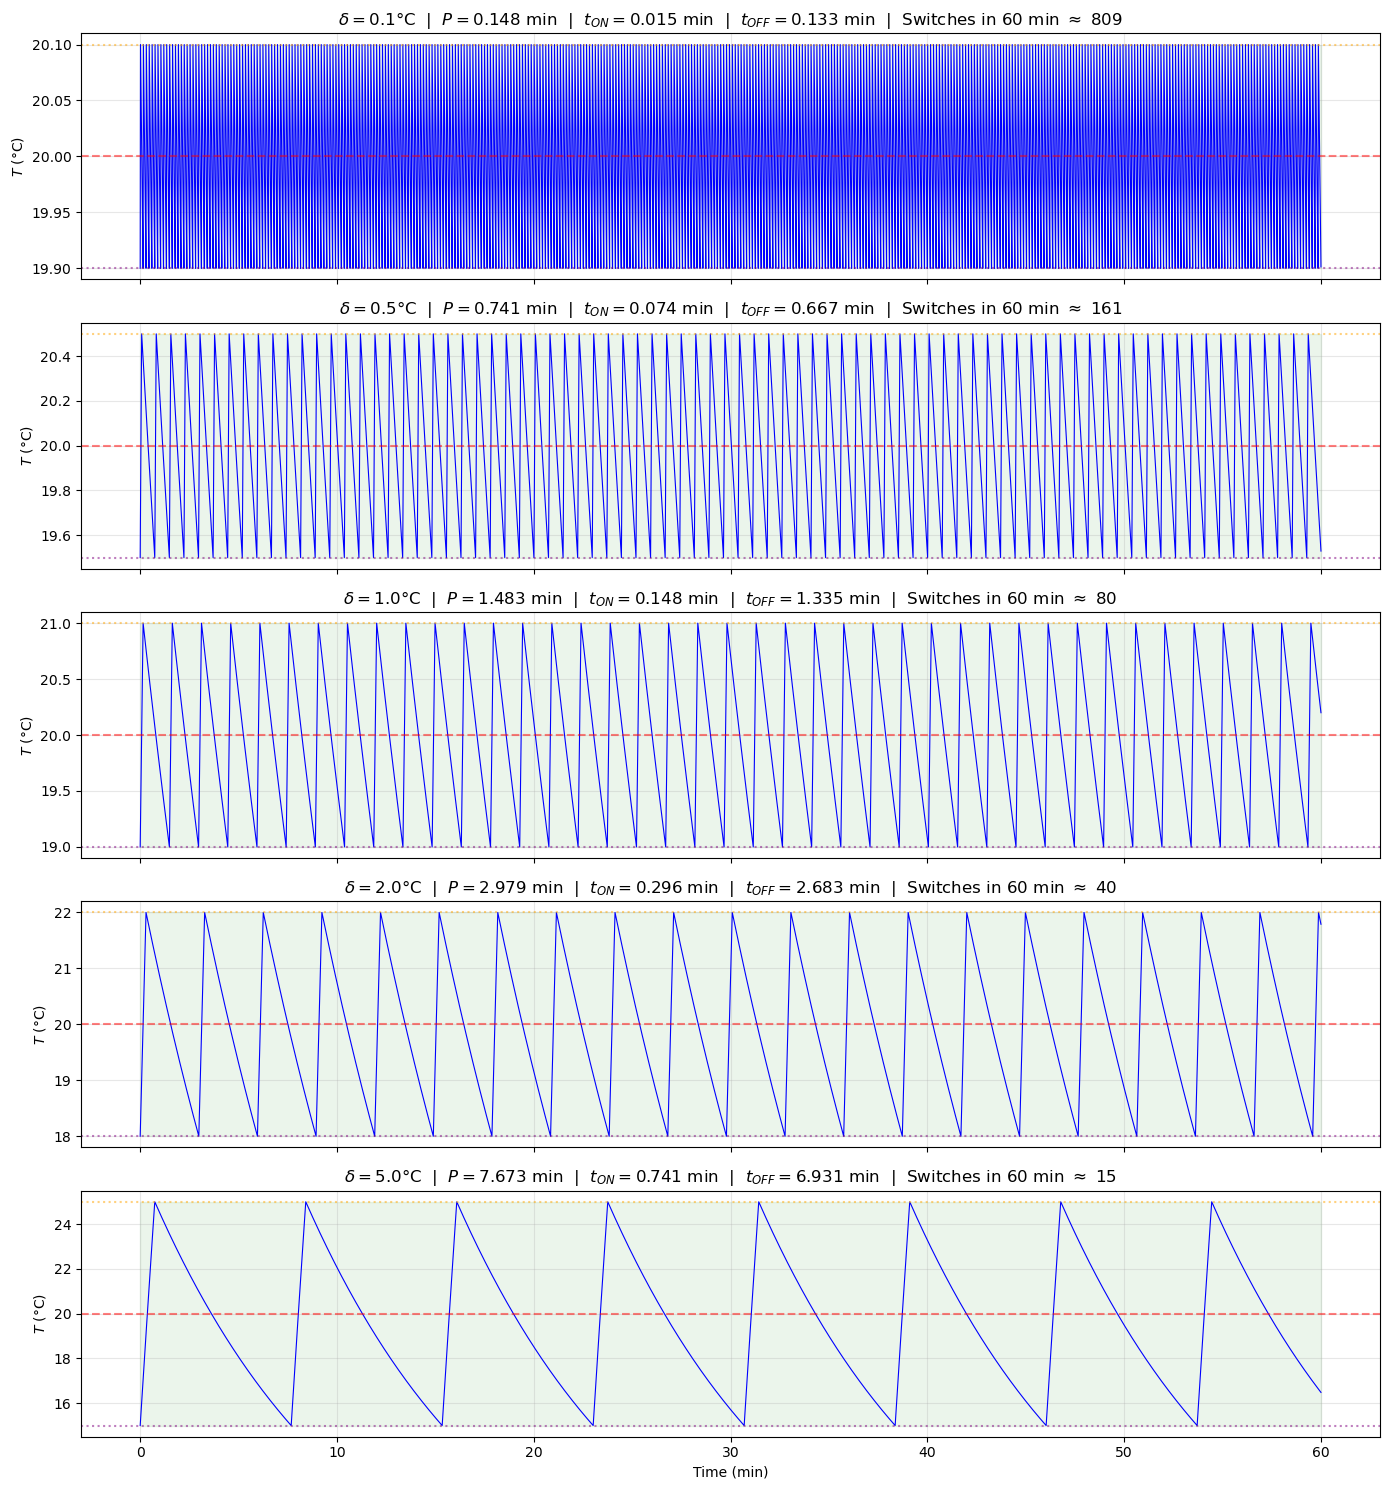

Saved: fig4_delta_comparison.png


In [7]:
# --- Figure 4: Oscillation comparison for different delta ---
delta_values = [0.1, 0.5, 1.0, 2.0, 5.0]

fig, axes = plt.subplots(len(delta_values), 1, figsize=(14, 3 * len(delta_values)), sharex=True)

for idx, delta_val in enumerate(delta_values):
    TH = T_set + delta_val
    TL = T_set - delta_val
    t_kai = compute_t_kai(TL, TH)
    t_guan = compute_t_guan(TL, TH)
    prd = t_kai + t_guan
    
    t_sim = []
    T_sim = []
    tc = 0
    sim_end = 60.0
    
    while tc < sim_end:
        dt_seg = min(t_kai, sim_end - tc)
        ts = np.linspace(0, dt_seg, max(int(dt_seg * 50), 20))
        Ts = T_on(ts, TL)
        t_sim.extend(ts + tc)
        T_sim.extend(Ts)
        tc += dt_seg
        if tc >= sim_end:
            break
        
        dt_seg = min(t_guan, sim_end - tc)
        ts = np.linspace(0, dt_seg, max(int(dt_seg * 50), 20))
        Ts = T_off(ts, TH)
        t_sim.extend(ts + tc)
        T_sim.extend(Ts)
        tc += dt_seg
    
    ax = axes[idx]
    ax.plot(t_sim, T_sim, 'b-', linewidth=0.8)
    ax.axhline(T_set, color='red', ls='--', alpha=0.5)
    ax.axhline(TH, color='orange', ls=':', alpha=0.5)
    ax.axhline(TL, color='purple', ls=':', alpha=0.5)
    ax.fill_between([0, sim_end], TL, TH, alpha=0.08, color='green')
    n_switches_total = int(2 * sim_end / prd) if prd > 0 else 0
    ax.set_ylabel('$T$ (°C)')
    ax.set_title(f'$\\delta = {delta_val}$°C  |  $P = {prd:.3f}$ min  |  '
                 f'$t_{{ON}} = {t_kai:.3f}$ min  |  $t_{{OFF}} = {t_guan:.3f}$ min  |  '
                 f'Switches in 60 min $\\approx$ {n_switches_total}')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (min)')
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig4_delta_comparison.png'), dpi=150)
plt.show()
print("Saved: fig4_delta_comparison.png")

## 4. Period, Energy Consumption, and Switching Cost Analysis

### Period
$$P = t_{\text{on}} + t_{\text{off}}$$

### Number of switches (over total time $T_{total}$)
$$N_{switches} = \frac{2}{P} \times T_{total} \quad \text{(each period has ON→OFF and OFF→ON, i.e. 2 events)}$$

### Energy consumption (per period)
$$E = \int_0^P u(t)\,dt = U_{max} \cdot t_{\text{on}} \quad \text{(no energy consumed when heater is OFF)}$$

### Switching energy cost
If each switch consumes energy $\epsilon$:
$$E_{switch} = N_{switches} \times \epsilon$$

### Total energy
$$E_{total} = \frac{T_{total}}{P}(U_{max} \cdot t_{\text{on}} + 2\epsilon)$$

### Combined cost (energy + comfort)
To find the **optimal $\delta$**, we balance energy and comfort (temperature deviation):

$$J(\delta) = \underbrace{E_{total}(\delta)}_{\text{energy}} + \underbrace{\lambda \cdot \text{RMSE}^2(\delta) \cdot T_{total}}_{\text{comfort penalty}}$$

where RMSE is computed by integrating $(T(t) - T_{set})^2$ over one period.

In [ ]:
# --- Key metrics table ---
T_total_sim = 120.0  # Total simulation time (min)
delta_range = [0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0]

print(f"{'delta':>6} {'T_H':>6} {'T_L':>6} {'t_on':>8} {'t_off':>8} {'Period':>8} {'Switches':>10} {'E/period':>10}")
print("-" * 75)

for d in delta_range:
    TH = T_set + d
    TL = T_set - d
    t_kai = compute_t_kai(TL, TH)
    t_guan = compute_t_guan(TL, TH)
    prd = t_kai + t_guan
    n_sw = 2.0 * T_total_sim / prd
    E_per_period = U_max * t_kai
    print(f"{d:>6.2f} {TH:>6.1f} {TL:>6.1f} {t_kai:>8.4f} {t_guan:>8.4f} {prd:>8.4f} {n_sw:>10.1f} {E_per_period:>10.4f}")

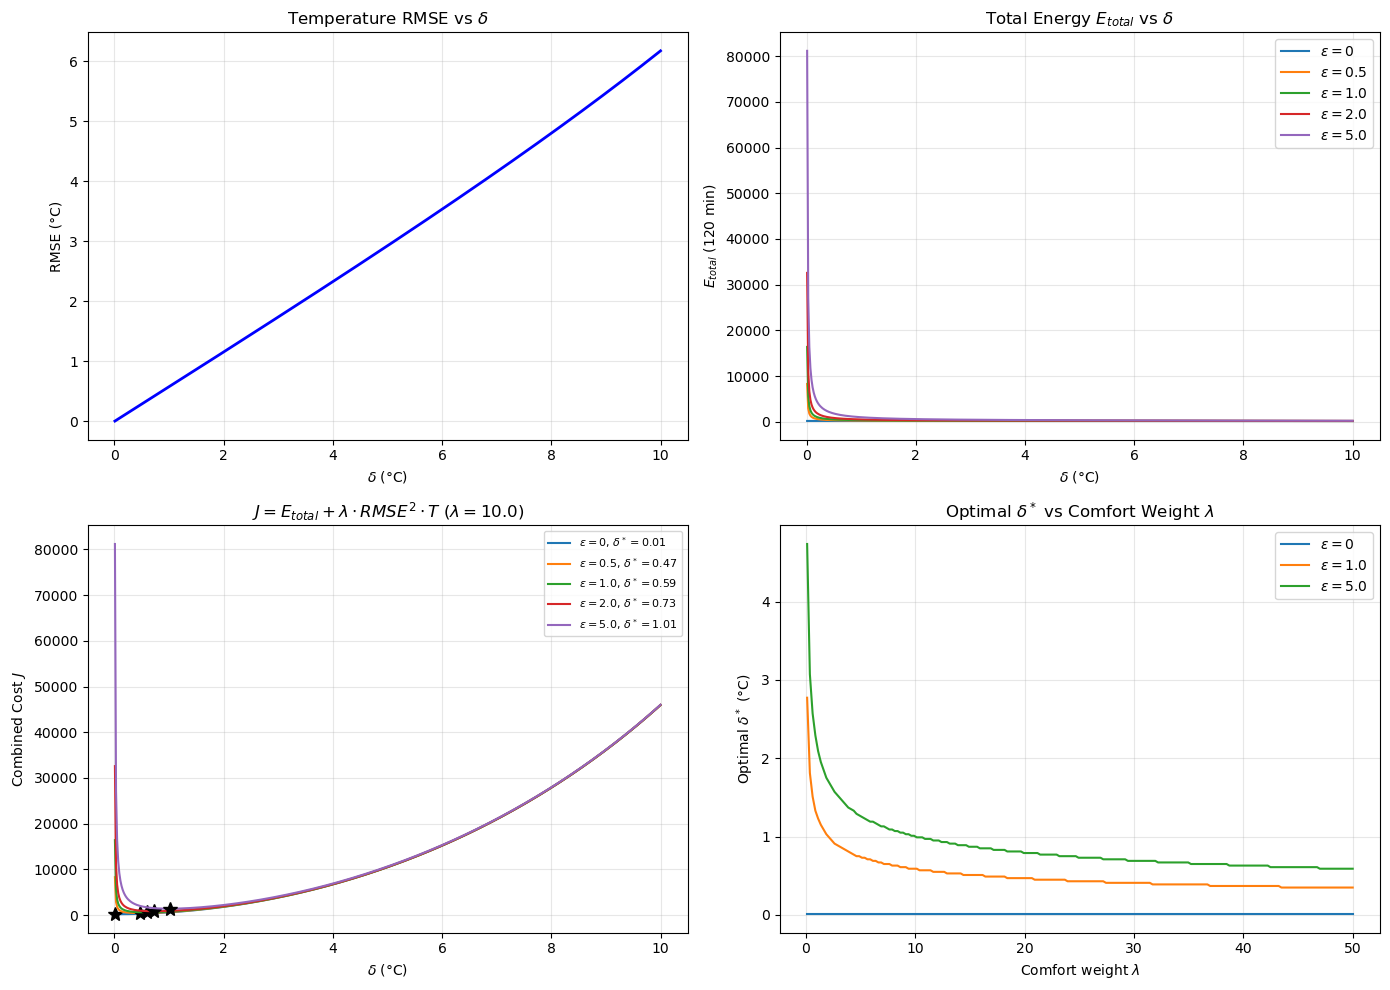

Saved: fig5_energy_optimal_delta.png


In [9]:
# --- Figure 5: Optimal delta (combined cost = energy + comfort) ---

def compute_rmse_squared_per_period(delta_val, k=k, T_a=T_a, U_max=U_max, T_set=T_set):
    """RMSE^2 over one Bang-Bang period. Numerical integration."""
    T_L = T_set - delta_val
    T_H = T_set + delta_val
    T_ss_val = T_a + U_max / k
    
    t_kai_val = compute_t_kai(T_L, T_H, k, T_a, U_max)
    t_guan_val = compute_t_guan(T_L, T_H, k, T_a)
    P = t_kai_val + t_guan_val
    
    if P <= 0 or np.isinf(P):
        return 0
    
    N = 500
    t_heat = np.linspace(0, t_kai_val, N)
    T_heat = T_ss_val + (T_L - T_ss_val) * np.exp(-k * t_heat)
    int_heat = np.trapz((T_heat - T_set)**2, t_heat)
    
    t_cool = np.linspace(0, t_guan_val, N)
    T_cool = T_a + (T_H - T_a) * np.exp(-k * t_cool)
    int_cool = np.trapz((T_cool - T_set)**2, t_cool)
    
    return (int_heat + int_cool) / P

deltas_fine = np.linspace(0.01, 10.0, 500)
epsilon_values = [0, 0.5, 1.0, 2.0, 5.0]
lam = 10.0

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) RMSE vs delta
ax = axes[0, 0]
rmse_vals = [np.sqrt(compute_rmse_squared_per_period(d)) for d in deltas_fine]
ax.plot(deltas_fine, rmse_vals, 'b-', linewidth=2)
ax.set_xlabel('$\\delta$ (°C)')
ax.set_ylabel('RMSE (°C)')
ax.set_title('Temperature RMSE vs $\\delta$')
ax.grid(True, alpha=0.3)

# (b) Total energy for various epsilon
ax = axes[0, 1]
for eps in epsilon_values:
    E_totals = []
    for d in deltas_fine:
        TL = T_set - d
        TH = T_set + d
        t_kai = compute_t_kai(TL, TH)
        t_guan = compute_t_guan(TL, TH)
        prd = t_kai + t_guan
        n_cycles = T_total_sim / prd
        E_heat = n_cycles * U_max * t_kai
        E_switch = n_cycles * 2 * eps
        E_totals.append(E_heat + E_switch)
    ax.plot(deltas_fine, E_totals, label=f'$\\epsilon = {eps}$')
ax.set_xlabel('$\\delta$ (°C)')
ax.set_ylabel(f'$E_{{total}}$ ({T_total_sim:.0f} min)')
ax.set_title(f'Total Energy $E_{{total}}$ vs $\\delta$')
ax.legend()
ax.grid(True, alpha=0.3)

# (c) Combined cost J for various epsilon
ax = axes[1, 0]
for eps in epsilon_values:
    J_vals = []
    for d in deltas_fine:
        TL = T_set - d
        TH = T_set + d
        t_kai = compute_t_kai(TL, TH)
        t_guan = compute_t_guan(TL, TH)
        prd = t_kai + t_guan
        n_cycles = T_total_sim / prd
        E_heat = n_cycles * U_max * t_kai
        E_switch = n_cycles * 2 * eps
        rmse2 = compute_rmse_squared_per_period(d)
        J = E_heat + E_switch + lam * rmse2 * T_total_sim
        J_vals.append(J)
    
    opt_idx = np.argmin(J_vals)
    ax.plot(deltas_fine, J_vals, label=f'$\\epsilon = {eps}$, $\\delta^* = {deltas_fine[opt_idx]:.2f}$')
    ax.plot(deltas_fine[opt_idx], J_vals[opt_idx], 'k*', markersize=10)

ax.set_xlabel('$\\delta$ (°C)')
ax.set_ylabel('Combined Cost $J$')
ax.set_title(f'$J = E_{{total}} + \\lambda \\cdot RMSE^2 \\cdot T$ ($\\lambda = {lam}$)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (d) Optimal delta vs lambda
ax = axes[1, 1]
for eps in [0, 1.0, 5.0]:
    lambdas = np.linspace(0.1, 50, 200)
    opt_ds = []
    for l in lambdas:
        J_vals = []
        for d in deltas_fine:
            TL = T_set - d
            TH = T_set + d
            t_kai = compute_t_kai(TL, TH)
            t_guan = compute_t_guan(TL, TH)
            prd = t_kai + t_guan
            n_cycles = T_total_sim / prd
            E_heat = n_cycles * U_max * t_kai
            E_switch = n_cycles * 2 * eps
            rmse2 = compute_rmse_squared_per_period(d)
            J_vals.append(E_heat + E_switch + l * rmse2 * T_total_sim)
        opt_ds.append(deltas_fine[np.argmin(J_vals)])
    ax.plot(lambdas, opt_ds, label=f'$\\epsilon = {eps}$')

ax.set_xlabel('Comfort weight $\\lambda$')
ax.set_ylabel('Optimal $\\delta^*$ (°C)')
ax.set_title('Optimal $\\delta^*$ vs Comfort Weight $\\lambda$')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig5_energy_optimal_delta.png'), dpi=150)
plt.show()
print("Saved: fig5_energy_optimal_delta.png")

In [ ]:
# --- Optimal delta table (combined cost) ---
print("Optimal delta* (combined cost J = E_total + lambda * RMSE^2 * T)")
print(f"(T_total = {T_total_sim} min)\n")

print(f"{'epsilon':>8} {'lambda':>8} {'delta*':>8} {'Period':>8} {'Switches':>10} {'E_total':>10} {'RMSE':>8} {'J':>10}")
print("-" * 80)

for eps in [0, 1.0, 5.0]:
    for l in [1.0, 5.0, 10.0, 20.0, 50.0]:
        J_vals = []
        for d in deltas_fine:
            TL = T_set - d
            TH = T_set + d
            t_kai = compute_t_kai(TL, TH)
            t_guan = compute_t_guan(TL, TH)
            prd = t_kai + t_guan
            n_cycles = T_total_sim / prd
            E_heat = n_cycles * U_max * t_kai
            E_switch = n_cycles * 2 * eps
            rmse2 = compute_rmse_squared_per_period(d)
            J_vals.append(E_heat + E_switch + l * rmse2 * T_total_sim)
        
        opt_idx = np.argmin(J_vals)
        d_opt = deltas_fine[opt_idx]
        TL_opt = T_set - d_opt
        TH_opt = T_set + d_opt
        t_kai_opt = compute_t_kai(TL_opt, TH_opt)
        t_guan_opt = compute_t_guan(TL_opt, TH_opt)
        P_opt = t_kai_opt + t_guan_opt
        n_sw = 2 * T_total_sim / P_opt
        E_t = (T_total_sim / P_opt) * (U_max * t_kai_opt + 2 * eps)
        rmse_opt = np.sqrt(compute_rmse_squared_per_period(d_opt))
        
        print(f"{eps:>8.1f} {l:>8.1f} {d_opt:>8.2f} {P_opt:>8.3f} {n_sw:>10.0f} {E_t:>10.1f} {rmse_opt:>8.3f} {J_vals[opt_idx]:>10.1f}")
    print()

## 5. Full Simulation: Startup Transient + Steady-State Oscillation

Starting from $T_{initial} = 10$°C, the heater first warms up to $T_H$, then enters periodic Bang-Bang oscillation.

Startup time (T_initial=10.0°C -> T_H=20.5°C): 0.752 min


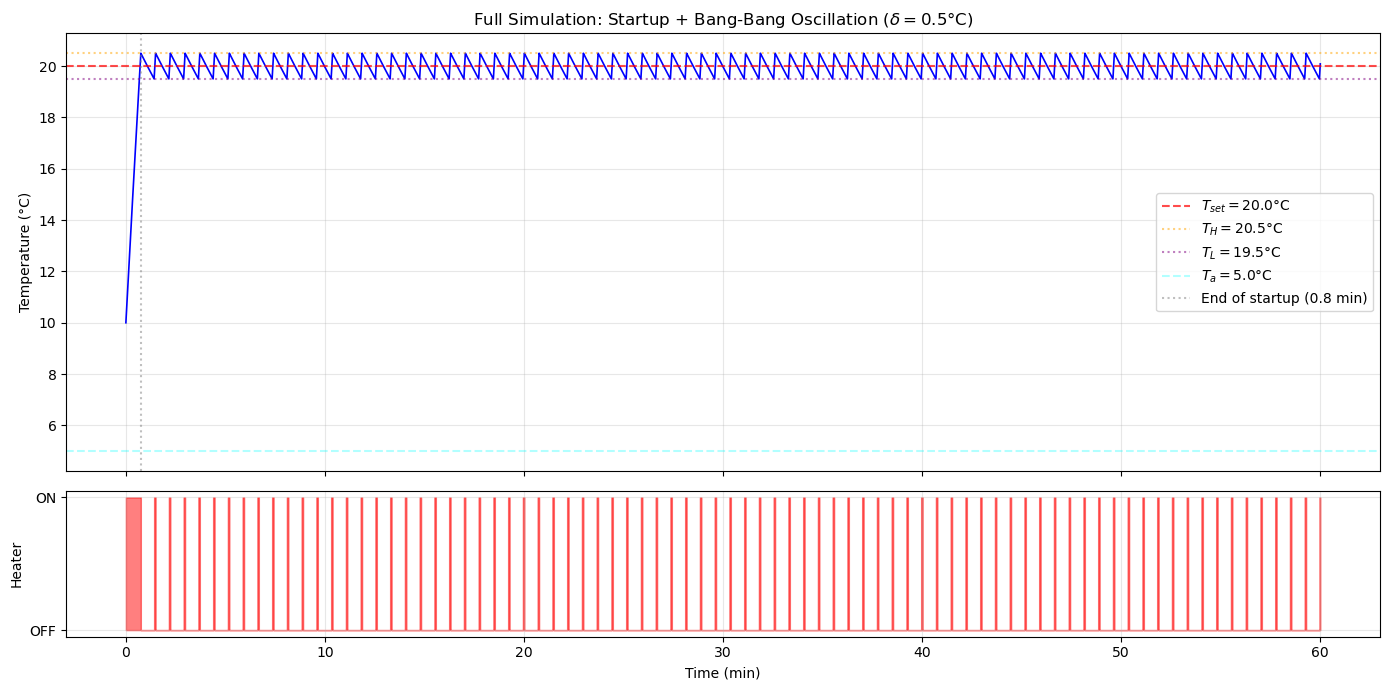

Saved: fig6_full_transient_simulation.png


In [11]:
# --- Figure 6: Full simulation (startup transient + steady oscillation) ---
delta = 0.5
T_H = T_set + delta
T_L = T_set - delta

t_startup = (1.0 / k) * np.log((T_initial - T_ss) / (T_H - T_ss))
print(f"Startup time (T_initial={T_initial}°C -> T_H={T_H}°C): {t_startup:.3f} min")

t_kai_val = compute_t_kai(T_L, T_H)
t_guan_val = compute_t_guan(T_L, T_H)

t_arr = []
T_arr = []
heater_arr = []
tc = 0
sim_end = 60.0

# Startup: T_initial -> T_H
ts = np.linspace(0, t_startup, 300)
Ts = T_on(ts, T_initial)
t_arr.extend(ts)
T_arr.extend(Ts)
heater_arr.extend([1] * len(ts))
tc = t_startup

# Steady oscillation
while tc < sim_end:
    dt_seg = min(t_guan_val, sim_end - tc)
    ts = np.linspace(0, dt_seg, 150)
    Ts = T_off(ts, T_H)
    t_arr.extend(ts + tc)
    T_arr.extend(Ts)
    heater_arr.extend([0] * len(ts))
    tc += dt_seg
    if tc >= sim_end:
        break
    
    dt_seg = min(t_kai_val, sim_end - tc)
    ts = np.linspace(0, dt_seg, 150)
    Ts = T_on(ts, T_L)
    t_arr.extend(ts + tc)
    T_arr.extend(Ts)
    heater_arr.extend([1] * len(ts))
    tc += dt_seg

t_arr = np.array(t_arr)
T_arr = np.array(T_arr)
heater_arr = np.array(heater_arr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), height_ratios=[3, 1], sharex=True)

ax1.plot(t_arr, T_arr, 'b-', linewidth=1.2)
ax1.axhline(T_set, color='red', ls='--', alpha=0.7, label=f'$T_{{set}} = {T_set}$°C')
ax1.axhline(T_H, color='orange', ls=':', alpha=0.5, label=f'$T_H = {T_H}$°C')
ax1.axhline(T_L, color='purple', ls=':', alpha=0.5, label=f'$T_L = {T_L}$°C')
ax1.axhline(T_a, color='cyan', ls='--', alpha=0.3, label=f'$T_a = {T_a}$°C')
ax1.axvline(t_startup, color='gray', ls=':', alpha=0.5, label=f'End of startup ({t_startup:.1f} min)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title(f'Full Simulation: Startup + Bang-Bang Oscillation ($\\delta = {delta}$°C)')
ax1.legend(loc='right')
ax1.grid(True, alpha=0.3)

ax2.fill_between(t_arr, heater_arr, step='mid', alpha=0.5, color='red')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Heater')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['OFF', 'ON'])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig6_full_transient_simulation.png'), dpi=150)
plt.show()
print("Saved: fig6_full_transient_simulation.png")

## 6. Analytical Results Summary

### Key Formulas (0D Bang-Bang + Hysteresis)

| Quantity | Formula |
|----------|---------|
| **Analytical solution** | $T(t) = T_a + \frac{u_t}{k} + e^{-k(t-t_0)}\left(T(t_0) - T_a - \frac{u_t}{k}\right)$ |
| **Heater OFF** ($u=0$) | $T_{\text{off}}(t) = T_a + (T(t_0) - T_a)\,e^{-k(t-t_0)}$ |
| **Heater ON** ($u=U_{max}$) | $T_{\text{on}}(t) = T_{ss} + (T(t_0) - T_{ss})\,e^{-k(t-t_0)}$, $T_{ss} = T_a + U_{max}/k$ |
| **Half-band $t_{\text{on}}$** (Step 1) | $t_{\text{on}} = \frac{1}{k}\ln\frac{T_{set}-\delta - T_{ss}}{T_{set} - T_{ss}}$ |
| **Half-band $t_{\text{off}}$** (Step 1) | $t_{\text{off}} = \frac{1}{k}\ln\frac{T_{set}+\delta - T_a}{T_{set} - T_a}$ |
| **Full-band $t_{\text{on}}$** (Step 2) | $t_{\text{on}} = \frac{1}{k}\ln\frac{T_L - T_{ss}}{T_H - T_{ss}}$ |
| **Full-band $t_{\text{off}}$** (Step 2) | $t_{\text{off}} = \frac{1}{k}\ln\frac{T_H - T_a}{T_L - T_a}$ |
| **Period** | $P = t_{\text{on}} + t_{\text{off}}$ |
| **Number of switches** | $N = \frac{2T_{total}}{P}$ |
| **Energy per period** | $E = U_{max} \cdot t_{\text{on}}$ |
| **Total energy** (with switching cost $\epsilon$) | $E_{total} = \frac{T_{total}}{P}(U_{max} \cdot t_{\text{on}} + 2\epsilon)$ |
| **Zeno effect** | $\delta \to 0$: $P \to 0$, $N \to \infty$ |

In [ ]:
# --- Final summary ---
print("=" * 60)
print("Summary: 0D Bang-Bang Analytical Results")
print("=" * 60)
print(f"\nParameters:")
print(f"  T_a = {T_a}°C (outdoor temperature)")
print(f"  T_set = {T_set}°C (set-point temperature)")
print(f"  k = {k} 1/min (cooling constant)")
print(f"  U_max = {U_max} °C/min (max heating rate)")
print(f"  T_ss = T_a + U_max/k = {T_ss}°C (steady-state, always ON)")

print(f"\n--- Different delta values ---")
for d in [0.1, 0.5, 1.0, 2.0, 5.0]:
    TH = T_set + d
    TL = T_set - d
    t_kai = compute_t_kai(TL, TH)
    t_guan = compute_t_guan(TL, TH)
    prd = t_kai + t_guan
    n_sw_120 = 2 * 120 / prd
    E_per_period = U_max * t_kai
    E_120 = (120 / prd) * E_per_period
    
    print(f"\n  delta = {d}°C -> T_L = {TL}°C, T_H = {TH}°C")
    print(f"    t_on = {t_kai:.4f} min, t_off = {t_guan:.4f} min, period P = {prd:.4f} min")
    print(f"    Switches in 120 min: {n_sw_120:.0f}")
    print(f"    Energy per period E = U_max * t_on = {E_per_period:.4f}")
    print(f"    Total heating energy in 120 min: {E_120:.1f}")